In [1]:
# ========================
# 1. Importações
# ========================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

In [2]:
# ==================
# 2. Carregar dados
# ==================
df = pd.read_csv("viagens_validas_com_lances.csv")    

In [3]:
print(df.dtypes)

TRIP_ID                  object
DATE.TIME..UTC.          object
Data                     object
Hora                     object
Tempo_Relativo_Horas    float64
Velocidade              float64
LATITUDE                float64
LONGITUDE               float64
which.PORT               object
Code                     object
fase_extracao             int64
inicio_lancamento         int64
duracao_lance           float64
lance_integrado           int64
dtype: object


In [4]:
# Analisar valores nulos
valores_nulos = df.isnull().sum()
nulos_presentes = valores_nulos[valores_nulos > 0]
if nulos_presentes.empty:
    print("O dataset não possui valores nulos.")
else:
    print("O dataset possui valores nulos nas seguintes colunas:")
    print(nulos_presentes)

O dataset possui valores nulos nas seguintes colunas:
which.PORT       1233872
duracao_lance    1549265
dtype: int64


In [5]:
# Ordenar o DataFrame por TRIP_ID e por data/hora
df = df.sort_values(by=["TRIP_ID", "DATE.TIME..UTC."])

# Criar as novas colunas de velocidade dos dois registos anteriores e dos dois seguintes (shift aplicado por grupo de TRIP_ID)
df["vel_anterior_1"] = df.groupby("TRIP_ID")["Velocidade"].shift(1).fillna(0)
df["vel_anterior_2"] = df.groupby("TRIP_ID")["Velocidade"].shift(2).fillna(0)

df["vel_seguinte_1"] = df.groupby("TRIP_ID")["Velocidade"].shift(-1).fillna(0)
df["vel_seguinte_2"] = df.groupby("TRIP_ID")["Velocidade"].shift(-2).fillna(0)

print(df.head())

         TRIP_ID      DATE.TIME..UTC.        Data      Hora  \
0  Vessel_111_10  2018-05-11 14:56:36  2018-05-11  14:56:36   
1  Vessel_111_10  2018-05-11 15:01:26  2018-05-11  15:01:26   
2  Vessel_111_10  2018-05-11 15:11:35  2018-05-11  15:11:35   
3  Vessel_111_10  2018-05-11 15:21:35  2018-05-11  15:21:35   
4  Vessel_111_10  2018-05-11 15:31:35  2018-05-11  15:31:35   

   Tempo_Relativo_Horas  Velocidade  LATITUDE  LONGITUDE which.PORT  \
0              0.000000         0.0  39.35589   -9.36883    Peniche   
1              0.080556         4.0  39.35515   -9.36794    Peniche   
2              0.249722         6.7  39.34754   -9.38373        NaN   
3              0.416389         6.8  39.34571   -9.40807        NaN   
4              0.583056         5.8  39.34532   -9.43133        NaN   

         Code  fase_extracao  inicio_lancamento  duracao_lance  \
0  Vessel_111              0                  0            NaN   
1  Vessel_111              0                  0            NaN

In [ ]:
# Substituir nulos em which.PORT e preparar duracao_lance
df['which.PORT'] = df['which.PORT'].fillna('não identificado')
print(df.head())
print(df.shape)

         TRIP_ID      DATE.TIME..UTC.        Data      Hora  \
0  Vessel_111_10  2018-05-11 14:56:36  2018-05-11  14:56:36   
1  Vessel_111_10  2018-05-11 15:01:26  2018-05-11  15:01:26   
2  Vessel_111_10  2018-05-11 15:11:35  2018-05-11  15:11:35   
3  Vessel_111_10  2018-05-11 15:21:35  2018-05-11  15:21:35   
4  Vessel_111_10  2018-05-11 15:31:35  2018-05-11  15:31:35   

   Tempo_Relativo_Horas  Velocidade  LATITUDE  LONGITUDE        which.PORT  \
0              0.000000         0.0  39.35589   -9.36883           Peniche   
1              0.080556         4.0  39.35515   -9.36794           Peniche   
2              0.249722         6.7  39.34754   -9.38373  não identificado   
3              0.416389         6.8  39.34571   -9.40807  não identificado   
4              0.583056         5.8  39.34532   -9.43133  não identificado   

         Code  fase_extracao  inicio_lancamento  duracao_lance  \
0  Vessel_111              0                  0            NaN   
1  Vessel_111       

In [7]:
# Remover colunas irrelevantes
colunas_a_remover = ["TRIP_ID", "DATE.TIME..UTC.", "Data", "duracao_lance", "Hora", "fase_extracao", "inicio_lancamento"]
df.drop(columns=colunas_a_remover, inplace=True)

In [8]:
# ========================
# 3. Separar X e y
# ========================
X = df.drop(columns=["lance_integrado"])
y = df["lance_integrado"]

# ========================
# 4. Divisão treino/teste
# ========================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ========================
# 5. Pré-processamento
# ========================
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

In [ ]:
# ========================
# 6. Modelo de Classificação
# ========================
modelos = {
    'Random Forest': RandomForestClassifier(random_state=42),
}

In [10]:
# ========================
# 7. Avaliação com Cross-Validation
# ========================

cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=1, random_state=42)
resultados = []

for nome, modelo in modelos.items():
    print(f"Avaliar modelo: {nome}...")
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', modelo)
    ])
    start = time.time()
    try:
        scores = cross_validate(pipe, X_train, y_train, cv=cv,
                                scoring=['accuracy', 'f1', 'roc_auc'],
                                n_jobs=-1)
        tempo_exec = round(time.time() - start, 2)
        resultados.append({
            'Modelo': nome,
            'Accuracy': round(scores['test_accuracy'].mean(), 3),
            'F1-Score': round(scores['test_f1'].mean(), 3),
            'ROC AUC': round(scores['test_roc_auc'].mean(), 3),
            'Tempo (s)': tempo_exec
        })
        print(f"Modelo {nome} avaliado com sucesso.\n")
    except Exception as e:
        print(f"Erro ao avaliar modelo {nome}: {e}\n")

df_resultados = pd.DataFrame(resultados).sort_values(by='F1-Score', ascending=False)
print("Resultados dos Modelos:")
print(df_resultados)

Avaliar modelo: Random Forest...
Modelo Random Forest avaliado com sucesso.

Resultados dos Modelos:
          Modelo  Accuracy  F1-Score  ROC AUC  Tempo (s)
0  Random Forest     0.964     0.886    0.988    6500.09


In [11]:
# ========================
# 8. Treinar e Avaliar o Modelo
# ========================
melhor_modelo_nome = df_resultados.iloc[0]['Modelo']
melhor_modelo = modelos[melhor_modelo_nome]

pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', melhor_modelo)
])

pipe_final.fit(X_train, y_train)
y_pred = pipe_final.predict(X_test)
y_proba = pipe_final.predict_proba(X_test)[:, 1]

print(f"\nAvaliação Final no Teste com o Modelo: {melhor_modelo_nome}")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall:", round(recall_score(y_test, y_pred), 3))
print("F1-Score:", round(f1_score(y_test, y_pred), 3))
print("ROC AUC:", round(roc_auc_score(y_test, y_proba), 3))
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))


Avaliação Final no Teste com o Modelo: Random Forest
Accuracy: 0.965
Precision: 0.891
Recall: 0.885
F1-Score: 0.888
ROC AUC: 0.989

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    309853
           1       0.89      0.89      0.89     58218

    accuracy                           0.96    368071
   macro avg       0.93      0.93      0.93    368071
weighted avg       0.96      0.96      0.96    368071



C:\Users\carlo\AppData\Local\Temp\ipykernel_9032\1911276819.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importância', y='Variável', data=df_importancia, palette='viridis')


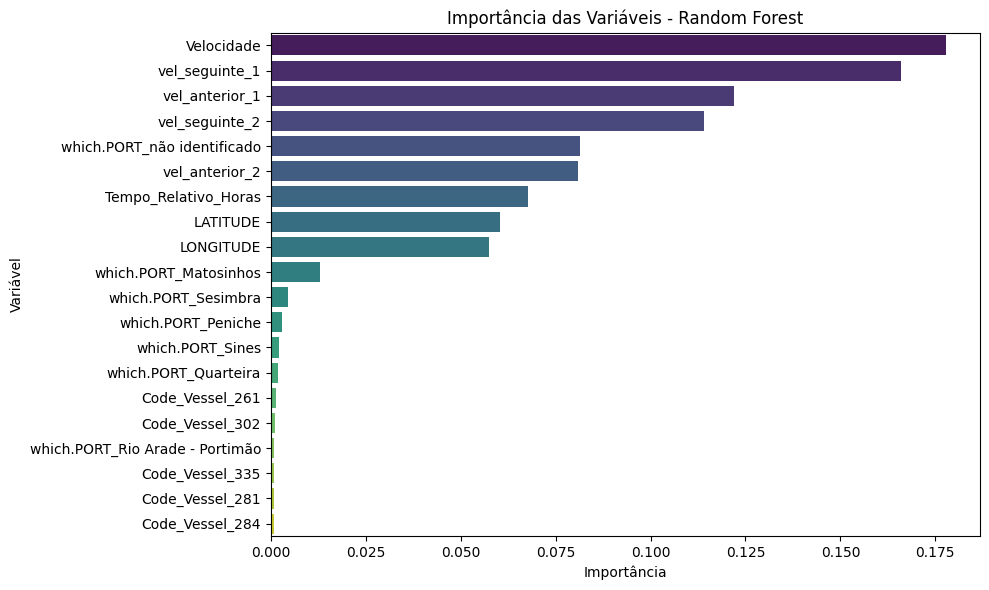

In [ ]:
# ========================
# 9. Importância das Variáveis
# ========================

# Apenas modelos com atributo de importância
modelos_com_importancia = (
    RandomForestClassifier
)

if isinstance(melhor_modelo, modelos_com_importancia):
    # Recupera os nomes das features após o ColumnTransformer
    nome_variaveis_numericas = num_cols.tolist()
    encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    nome_variaveis_categoricas = encoder.get_feature_names_out(cat_cols).tolist()

    nomes_finais_features = nome_variaveis_numericas + nome_variaveis_categoricas

    # Treinar modelo final fora do pipeline para obter importâncias
    modelo_treinado = melhor_modelo.fit(
        preprocessor.fit_transform(X_train), y_train
    )
    importancias = modelo_treinado.feature_importances_

    # Criar DataFrame e gráfico
    df_importancia = pd.DataFrame({
        'Variável': nomes_finais_features,
        'Importância': importancias
    }).sort_values(by='Importância', ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importância', y='Variável', data=df_importancia, palette='viridis')
    plt.title(f"Importância das Variáveis - {melhor_modelo_nome}")
    plt.tight_layout()
    plt.show()

elif isinstance(melhor_modelo, LogisticRegression):
    # Recupera os nomes das features após o ColumnTransformer
    nome_variaveis_numericas = num_cols.tolist()
    encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
    nome_variaveis_categoricas = encoder.get_feature_names_out(cat_cols).tolist()
    nomes_finais_features = nome_variaveis_numericas + nome_variaveis_categoricas

    # Treinar modelo fora do pipeline
    modelo_treinado = melhor_modelo.fit(preprocessor.fit_transform(X_train), y_train)
    coeficientes = modelo_treinado.coef_[0]

    df_coef = pd.DataFrame({
        'Variável': nomes_finais_features,
        'Coeficiente': coeficientes
    }).sort_values(by='Coeficiente', key=np.abs, ascending=False).head(20)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coeficiente', y='Variável', data=df_coef, palette='coolwarm')
    plt.title(f"Coeficientes das Variáveis - {melhor_modelo_nome}")
    plt.tight_layout()
    plt.show()

else:
    print(f"O modelo {melhor_modelo_nome} não fornece importâncias diretamente.")

In [13]:
# ========================
# 10. Guardar previsões (com dataset completo)
# ========================
print("\nGerar previsões para todo o conjunto de dados...")

# Treinar novamente o modelo com TODOS os dados disponíveis
pipe_final.fit(X, y)

# Fazer previsões para todo o dataset
y_pred_full = pipe_final.predict(X)

# Criar uma cópia do DataFrame original
df_original = pd.read_csv("viagens_validas_com_lances.csv")

# Ajustar o índice para alinhar com o X usado na previsão
df_original = df_original.loc[X.index]

# Adicionar a coluna com as previsões
df_original["Valor Previsto"] = y_pred_full

# Guardar o novo dataset
df_original.to_csv("viagens_validas_com_previsao_RF.csv", index=False)
print("Novo dataset guardado como 'viagens_validas_com_previsao_RF.csv'")


Gerar previsões para todo o conjunto de dados...
Novo dataset guardado como 'viagens_validas_com_previsao_RF.csv'


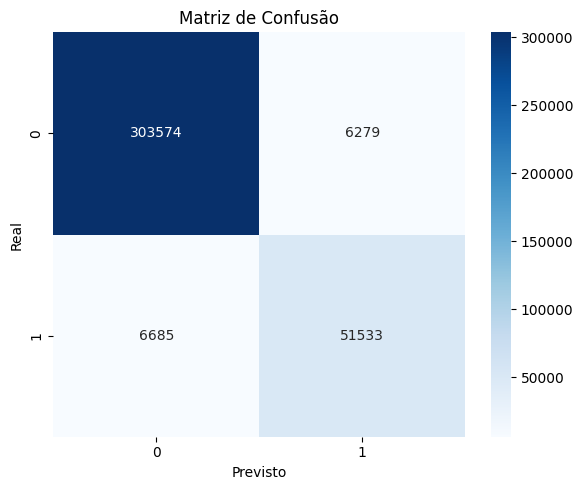

In [14]:
# ========================
# 11. Matriz de Confusão
# ========================
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.tight_layout()
plt.show()